# Cohort 400 ratios AUCs analysis (a/c + b/c)

### Imports and environment setup

- Date of run: 2024-09-16
- Environment: python 3.12
- Packages required: pandas, numpy, sklearn, statsmodels, seaborn, matplotlib

In [1]:
# Include in the environment the code directory with the utils function
import sys
sys.path.append('../code/')

In [2]:
# Library imports
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Utils imports
import cohort_analysis_utils as utils
import ms_utils

In [3]:
# Remove warnings for readability
import warnings
warnings.filterwarnings('ignore')

# Remove cell printing limits
pd.set_option('display.max_rows', None)

# Data loading and preprosessing

For this analysis, we are going to work with the MS ratios file ─located at ["data/ms/Womec_targetedDIA_ratio.csv"](<../data/ms/Womec_targetedDIA_ratio.csv>)─. In the same folders there are files for MS areas, untargeted MS, metadata from the patients and protein data.

In [4]:
METADATA_PATH = '../data/ms/Womec_DIA_patients.csv'
WOMEC_DIA_PATH = '../data/ms/Womec_targetedDIA_ratio.csv'
PROTEIN_DATA_PATH = '../data/ms/Womec_DIA_protein_data.csv'

# Key field to link the metadata with the WOMEC data
KEY_COLUMN = 'filename_womec'


In [5]:
# Load, harmonize and merge the data with the metadata
df_400 = ms_utils.load_data_with_metadata(WOMEC_DIA_PATH, METADATA_PATH, KEY_COLUMN)

In [6]:
# Different peptides for the same protein will have the same column name, rename then as _0, _1, _2, etc.
df_400 = ms_utils.rename_duplicated_columns(df_400)

In [7]:
# Ensure categorical columns are treated as such
df_400 = utils.cols_as_category(df_400, {'Condition':{'Benigna': 0, 'EC': 1, 'Sarcoma uterino': 1}})

In [8]:
# Define the biomarkers columns
BIOMARKERS_400 = list(df_400.columns[17:])

In [9]:
# Ensure numerical columns are treated as such
df_400 = utils.cols_as_numbers(df_400, BIOMARKERS_400)

In [10]:
# We load in a separate dataframe the protein data
df_protein_data = pd.read_csv(PROTEIN_DATA_PATH, sep='\t', index_col='Genes', header=0)

# Computing the models

In [11]:
# General params
RESULTS_PATH = '../data/results/400'

We will consider only the biomarkers with at least 100 samples for Benign and Cancer conditions with an individual AUC of at least 0.65

In [12]:
# Load the results
df_400_results_direct_max_1 = pd.read_csv(f'{RESULTS_PATH}/direct/max_1.csv', sep=',', index_col=0, header=0)

In [13]:
# Filter out the models that are not significant
BEST_BIOMARKERS = []

for biomarker in df_400_results_direct_max_1.index:
    if df_400_results_direct_max_1.loc[biomarker, 'AUC'] > 0.7:
        # Require the biomarker to appear in at least 100 samples of each condition
        if df_400[df_400['Condition'] == 1][biomarker].notna().sum() > 100 and (df_400[df_400['Condition'] == 0][biomarker].notna()).sum() > 100:
            BEST_BIOMARKERS.append(biomarker)

In [14]:
print(f"{len(set([bmk.split('_')[0] for bmk in BEST_BIOMARKERS]))} biomarkers have an AUC > 0.65 and appear in at least 100 samples of each condition")

53 biomarkers have an AUC > 0.65 and appear in at least 100 samples of each condition


We will consider for computing biomarker ratios only the relevant biomarkers (those with AUC > 0.65 and 100 for each condition)

In [15]:
# This is costly, so is commented out to compute it only once

_ = utils.compute_all_models_and_save(df=df_400, 
                                      biomarkers=BEST_BIOMARKERS, 
                                      target_col='Condition', 
                                      methods=['biomarker_ratio'], 
                                      max_biomarker_count=3,
                                      folder_name=RESULTS_PATH,
                                      auc_threshold=0.85)

# Results

Expectedly, as was happening with the usual AUC analysis, the biomarkers ratios with best performance are those with oposite tendencies. But in this scenario, they present slightly smaller AUCs than the classical models.

In [16]:
df_400_results_biomarker_ratio_max_3 = pd.read_csv(f'{RESULTS_PATH}/biomarker_ratio/max_3.csv', sep=',', index_col=[0,1], header=0)
df_400_results_biomarker_ratio_max_3.head(15)

,,Biomarker_3,AUC,Sensitivity,Specificity,NPV,PPV,Best_Threshold
Biomarker_1,Biomarker_2,,,,,,,
LDHA_0,NAMPT_1,DCN_1,0.89792,0.95023,0.28369,0.78431,0.67524,0.60606
NAMPT_1,LDHA_0,DCN_1,0.89792,0.95023,0.28369,0.78431,0.67524,0.60606
UGDH_2,S100A12,DCN_1,0.89454,0.96154,0.33673,0.82500,0.72917,0.53535
S100A12,UGDH_2,DCN_1,0.89454,0.96154,0.33673,0.82500,0.72917,0.53535
TARS1_2,VPS35_0,DCN_1,0.89430,0.95735,0.41860,0.85714,0.72924,0.51515
VPS35_0,TARS1_2,DCN_1,0.89430,0.95735,0.41860,0.85714,0.72924,0.51515
TARS1_2,PSMD2,DCN_1,0.89392,0.95755,0.40157,0.85000,0.72760,0.52525
PSMD2,TARS1_2,DCN_1,0.89392,0.95755,0.40157,0.85000,0.72760,0.52525
ENO1_0,DCN_1,UGDH_2,0.89283,0.95045,0.33846,0.80000,0.71044,0.21212


<Axes: xlabel='DCN_1', ylabel='Count'>

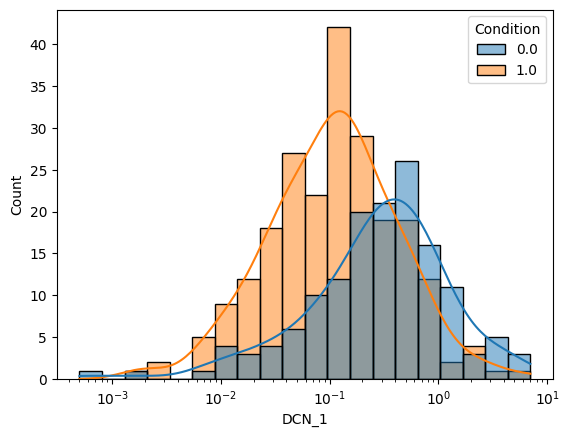

In [17]:
sns.histplot(df_400, x='DCN_1', hue='Condition', bins=20, kde=True, log_scale=True)


<Axes: xlabel='NAMPT_1', ylabel='Count'>

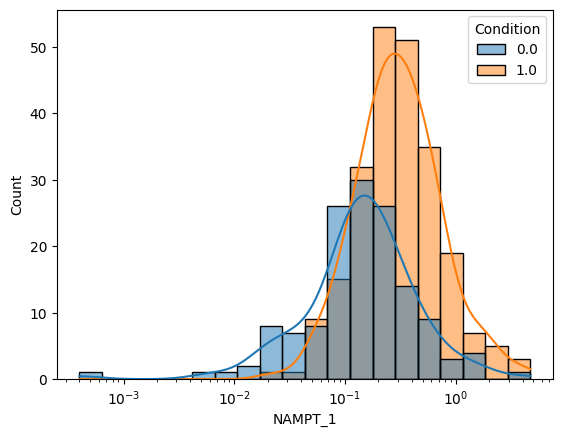

In [19]:
sns.histplot(df_400, x='NAMPT_1', hue='Condition', bins=20, kde=True, log_scale=True)

In [20]:
df_400_results_direct_max_3 = pd.read_csv(f'{RESULTS_PATH}/direct/max_3.csv', sep=',', index_col=[0,1,2], header=0)
df_400_results_direct_max_3.head(15)

AUC  Sensitivity  Specificity  \
Biomarker_1 Biomarker_2 Biomarker_3                                      
DCN_1       FASN        AGRN_0       0.90802      0.95392      0.34959   
            ENO1_0      GSTP1_1      0.90134      0.96226      0.28788   
FASN        DCN_0       AGRN_0       0.90122      0.95673      0.41880   
DCN_1       CACYBP_1    AGRN_0       0.90046      0.95045      0.34586   
FASN        LDHA_0      DCN_0        0.89933      0.95215      0.26400   
            LDHA_1      DCN_0        0.89844      0.95215      0.27419   
DCN_1       VPS35_0     LDHA_0       0.89790      0.95305      0.30597   
            FASN        MVP_0        0.89769      0.95455      0.31818   
                        LDHA_0       0.89747      0.96364      0.27820   
            ENO1_0      FASN         0.89728      0.95455      0.28788   
ENO1_0      FASN        DCN_0        0.89678      0.95694      0.32258   
DCN_1       FASN        LDHA_1       0.89669      0.95455      0.27273   
            GSTP1_1     LDHA_0       0.89623      0.95283      0.33835   
                        FASN         0.89581      0.95169      0.39167   
            FASN        GMDS_2       0.89571      0.95434      0.24615   

                                         NPV      PPV  Best_Threshold  
Biomarker_1 Biomarker_2 Biomarker_3                                    
DCN_1       FASN        AGRN_0       0.81132  0.72125         0.32323  
            ENO1_0      GSTP1_1      0.82609  0.68456         0.20202  
FASN        DCN_0       AGRN_0       0.84483  0.74532         0.36364  
DCN_1       CACYBP_1    AGRN_0       0.80702  0.70805         0.33333  
FASN        LDHA_0      DCN_0        0.76744  0.68385         0.30303  
            LDHA_1      DCN_0        0.77273  0.68858         0.31313  
DCN_1       VPS35_0     LDHA_0       0.80392  0.68581         0.37374  
            FASN        MVP_0        0.80769  0.70000         0.32323  
                        LDHA_0       0.82222  0.68831         0.31313  
            ENO1_0      FASN         0.79167  0.69079         0.33333  
ENO1_0      FASN        DCN_0        0.81633  0.70423         0.35354  
DCN_1       FASN        LDHA_1       0.78261  0.68627         0.32323  
            GSTP1_1     LDHA_0       0.81818  0.69655         0.24242  
                        FASN         0.82456  0.72963         0.34343  
            FASN        GMDS_2       0.76190  0.68078         0.25253

Let's compare the AUCs for the same indices in the two dataframes.

<Axes: xlabel='AUC', ylabel='Count'>

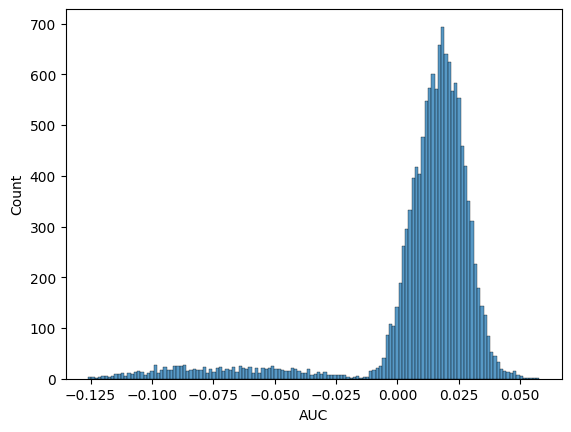

In [22]:
sns.histplot(df_400_results_direct_max_3['AUC'] - df_400_results_biomarker_ratio_max_3['AUC'])

As can be observed, very few have a a bigger AUC and by very small margin, but generally the AUCs of the ratios are generally small.